In [29]:
from pydantic import BaseModel, ConfigDict, Field, ValidationError
import json
import yaml
from pathlib import Path
from typing import Protocol, runtime_checkable, Tuple
import pandas as pd
import numpy as np
import narwhals as nw
import time
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Configurations

In [56]:
# =============================
# Pydantic Configuration Models
# =============================

class StrategyConfig(BaseModel):
    """
    A strategy config with settings related to risk appetite, vol targeting, leverage limits.
    """
    model_config = ConfigDict(frozen=True, extra='forbid')

    target_volatility: float = Field(default=0.10, gt=0.0, le=0.50, description="Annualized target volatility")
    vol_lookback: int = Field(default=22, gt=1, description="Lookback window size for target volatility")
    use_ewma: bool = Field(default=True, description="Use of EWMA (True) or plain realised volatility (False) for target volatility")
    ewma_vol_decay: float = Field(default=0.90, gt=0.0, lt=1.0, description="Decay parameter for EWMA volatility - faster adaptation")
    max_leverage: float = Field(default=3.0, gt=1.0, description="Maximum leverage from vol targeting")
    min_leverage: float = Field(default=0.02, gt=0.0, description="Minimum leverage from vol targeting - lower bound for flexibility"
    )
    max_gross_leverage: float = Field(default=2.0, gt=0.0, description="Hard cap on gross exposure")
    max_position_size: float = Field(default=0.05, gt=0.0, le=0.50, description="Max absolute weight per stock")

    # Cross-field validation
    def model_post_init(self, __context) -> None:
        if self.min_leverage > self.max_leverage:
            raise ValueError("min_leverage must be <= max_leverage")
            
class FactorConfig(BaseModel):
    """
    A factor config with settings related to the factor modelling.
    """
    model_config = ConfigDict(frozen=True, extra='forbid')

    correlation_lookback: int = Field(default=252, ge=60, description="Lookback days for correlation/PCA")
    use_mp_cleaning: bool = Field(default=True, description="Apply Marchenko-Pastur cleaning")
    use_rie: bool = Field(default=False, description="Use rotationally invariant estimator") # DEFAULT FALSE FOR NOW, TO BE CHANGED TO TRUE
    rie_method: str = Field(default="optimal", description="Method for RIE")
    use_ewma_corr: bool = Field(default=True, description="Use EWMA correlation for factor model")
    ewma_corr_decay: float = Field(default=0.94, gt=0.0, lt=1.0, description="Decay for EWMA correlation")

class SignalConfig(BaseModel):
    """
    A signal config with settings handling mean reversion threshold, long/short open/close thresholds, sizing.
    """
    model_config = ConfigDict(frozen=True, extra='forbid')

    kappa_threshold: float = Field(default=2.8, gt=0.0, description="Mean reversion threshold")
    s_score_open_long: float = Field(default=1.9, gt=0.0, description="s-score threshold for opening a long position")
    s_score_open_short: float = Field(default=1.9, gt=0.0, description="s-score threshold for opening a short position")
    s_score_close_long: float = Field(default=0.75, gt=0.0, description="s-score threshold for closing a long position")
    s_score_close_short: float = Field(default=0.75, gt=0.0, description="s-score threshold for closing a short position")
    prop_scaling_factor: float = Field(default=1.0, gt=0.0, description="Scaling for dynamic proportional sizing")
    prop_min_size: float = Field(default=0.3, ge=0.0, le=1.0, description="Lower bound for the proportional size")
    prop_max_size: float = Field(default=1.8, ge=0.0, description="Upper bound for the proportional size")

    # Cross-field validation
    def model_post_init(self, __context) -> None:
        if self.prop_min_size > self.prop_max_size:
            raise ValueError("prop_min_size must be <= prop_max_size")
        if self.s_score_close_long > self.s_score_open_long:
            raise ValueError("Close threshold must be <= open threshold for long positions")
        if self.s_score_close_short > self.s_score_open_short:  # Added check for short
            raise ValueError("Close threshold must be <= open threshold for short positions")

class RootConfig(BaseModel):
    """
    A root config to load everything from one file.
    """
    model_config = ConfigDict(frozen=True, extra='forbid')

    strategy: StrategyConfig = StrategyConfig()
    factor: FactorConfig = FactorConfig()
    signal: SignalConfig = SignalConfig()

# ==================
# Loading from JSON
# ==================

def load_config_from_json(file_path: str | Path) -> RootConfig:
    """
    Load the full configuration from a single JSON file.
    
    Example JSON structure (config.json):
    {
        "strategy": {
            "target_volatility": 0.12,
            "max_leverage": 4.0
        },
        "factor": {
            "correlation_lookback": 252
        },
        "signal": {
            "kappa_threshold": 3.0
        }
    }
    """
    path = Path(file_path)
    if not path.exists():
        raise FileNotFoundError(f"Config file not found: {path}")
    
    try:
        data = json.loads(path.read_text())
        return RootConfig.model_validate(data)
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON in config file: {e}")
    except ValidationError as e:
        raise ValueError(f"Config validation failed: {e.errors()}")

# ==================
# Loading from YAML
# ==================
def load_config_from_yaml(file_path: str | Path) -> RootConfig:
    path = Path(file_path)
    if not path.exists():
        raise FileNotFoundError(f"Config file not found: {path}")
    
    try:
        data = yaml.safe_load(path.read_text())
        return RootConfig.model_validate(data)
    except yaml.YAMLError as e:
        raise ValueError(f"Invalid YAML: {e}")
    except ValidationError as e:
        raise ValueError(f"Config validation failed: {e.errors()}")

In [31]:
# Example usage
# config = load_config_from_json("config.json")
config = load_config_from_yaml("config.yaml")
strat_cfg = config.strategy
factor_cfg = config.factor
signal_cfg = config.signal

In [32]:
print(f"Strategy Config: {strat_cfg}")
print(f"Factor Config: {factor_cfg}")
print(f"Signal Config: {signal_cfg}")

Strategy Config: target_volatility=0.16 vol_lookback=42 use_ewma=True ewma_vol_decay=0.94 max_leverage=4.5 min_leverage=0.15 max_gross_leverage=3.0 max_position_size=0.1
Factor Config: correlation_lookback=252 use_mp_cleaning=True use_rie=True rie_method='optimal' use_ewma_corr=True ewma_corr_decay=0.94
Signal Config: kappa_threshold=1.9 s_score_open_long=1.55 s_score_open_short=1.55 s_score_close_long=0.55 s_score_close_short=0.55 prop_scaling_factor=1.2 prop_min_size=0.5 prop_max_size=2.5


# Interfaces

In [33]:
# ===================
# Protocol Interfaces
# ===================
#
# Protocols use narwhals for DataFrame/Series operations to support both pandas and polars 
# 

@runtime_checkable
class FactorModel(Protocol):
    """Protocol for factor decomposition models."""

    def fit(self, returns: nw.DataFrame) -> None:
        """
        Fit the factor model on historical returns.
        
        Parameters
        ----------
        returns : nw.DataFrame
            Historical asset returns (rows = dates, columns = assets).
        """
        ...

    def get_factor_returns(self, returns: nw.DataFrame) -> nw.DataFrame:
        """
        Compute factor portfolio returns for a window of data.
        
        Returns
        -------
        nw.DataFrame
            Factor returns (rows = dates, columns = factors).
        """
        ...

    def get_factor_loadings(self, returns: nw.DataFrame) -> nw.DataFrame:
        """
        Compute factor exposures (betas) for each asset.
        
        Returns
        -------
        nw.DataFrame
            Loadings matrix (rows = assets, columns = factors) or similar.
        """
        ...


@runtime_checkable
class SignalGenerator(Protocol):
    """Protocol for generating mispricing signals from residuals."""

    def generate(self, residuals: nw.DataFrame) -> nw.Series:
        """
        Generate s-scores (or equivalent) from idiosyncratic residuals.
        
        Parameters
        ----------
        residuals : nw.DataFrame
            Asset-specific residuals after factor hedging (rows = dates, columns = assets).
        
        Returns
        -------
        nw.Series
            Latest signal per asset (index = assets).
        """
        ...


@runtime_checkable
class PositionSizer(Protocol):
    """Protocol for converting signals + loadings into hedged positions."""

    def size_positions(
        self,
        signals: nw.Series,
        loadings: nw.DataFrame,
        current_positions: nw.DataFrame,
    ) -> nw.DataFrame:
        """
        Compute new dollar-neutral positions including factor hedges.
        
        Parameters
        ----------
        signals : nw.Series
            Current mispricing signals (per asset).
        loadings : nw.DataFrame
            Factor exposures for hedging.
        current_positions : nw.DataFrame
            Existing positions (for entry/exit logic).
        
        Returns
        -------
        nw.DataFrame
            Updated positions (typically single row or full history).
        """
        ...


@runtime_checkable
class RiskOverlay(Protocol):
    """Protocol for post-processing positions with risk controls (e.g., vol targeting)."""

    def apply(
        self,
        portfolio_returns: nw.Series,
        positions: nw.DataFrame,
    ) -> nw.DataFrame:
        """
        Apply risk adjustments (e.g., leverage scaling).
        
        Parameters
        ----------
        portfolio_returns : nw.Series
            Historical strategy returns (for volatility estimation).
        positions : nw.DataFrame
            Raw positions from PositionSizer.
        
        Returns
        -------
        nw.DataFrame
            Risk-adjusted positions.
        """
        ...

# Implementation

In [34]:
def safe_normalize(row: nw.Series) -> nw.Series:
    """
    Safely normalize a row of weights by gross exposure (sum of absolute values).
    Handles zero totals and NaN cases.    
    
    Parameters
    ----------
    row : nw.Series
        Row of position weights to normalize.
        
    Returns
    -------
    nw.Series
        Normalized weights (gross exposure = 1.0) or zeros if invalid.
    """
    # Fill NaNs early to avoid propagation
    row = row.fill_nan(0.0)
    
    total = row.abs().sum() # Sum of absolute values, gross notional exposure
    if total == 0 or np.isnan(total):
        return row * 0  # Return zeros if no positions
    return row / total


def enforce_position_limits(
    weights: nw.Series,
    max_position: float = 0.05
) -> nw.Series:
    """
    Enforce symmetric per-position size limits (long/short allowed).
    
    Parameters
    ----------
    weights : nw.Series
        Position weights
    max_position : float
        Maximum weight per asset as fraction of portfolio.
        
    Returns
    -------
    nw.Series
        Clipped weights in (-max_position, max_position).
    """
    if max_position <= 0:
        raise ValueError("max_position must be positive")

    weights = weights.fill_nan(0.0)
    return weights.clip(lower_bound=-max_position, upper_bound=max_position)    


def enforce_leverage_limits(
    weights: nw.Series, 
    max_gross: float = 2.0
) -> nw.Series:
    """
    Enforce maximum gross leverage cap.
    
    Scales down positions proportionally if gross exposure exceeds limit.
    No minimum enforced here (handled by vol targeting overlay separately).
    
    Parameters
    ----------
    weights : nw.Series
        Position weights.
    max_gross : float
        Maximum gross exposure.
        
    Returns
    -------
    nw.Series
        Scaled weights (gross <= max_gross).
    """

    gross = weights.abs().sum()
    if gross > max_gross:
        weights = weights * (max_gross / gross)
    return weights

In [35]:
def get_portfolio(weights: np.ndarray, stocks: list, norm: bool = True) -> nw.Series:
    """
    Create a portfolio Series given weights and stocks.

    Parameters
    ----------
    weights : np.ndarray
        Portfolio weights
    stocks : list
        List of stock names
    norm : bool, optional
        Whether to normalize weights, by default True
        
    Returns
    -------
    nw.Series
        Portfolio weights as Series
    """
    if norm:
        weight_sum = np.sum(np.abs(weights))
        if not np.isclose(weight_sum, 1.0, atol=1e-10):
            weights = weights / weight_sum if weight_sum > 0 else weights
    
    portfolio_weights = nw.Series.from_numpy(
        name="weights",
        values=weights, 
        backend="pandas"
    )
    return portfolio_weights


def get_portfolio_set_returns(weights_df: nw.DataFrame, stock_returns: nw.DataFrame) -> nw.DataFrame:
    """
    Compute the returns for each portfolio defined by a set of weights.

    Parameters
    ----------
    weights_df : nw.DataFrame (1,n_stcoks)
        DataFrame containing weights for different portfolios
    stock_returns : nw.DataFrame (n_dates,n_stcoks)
        DataFrame containing historical returns for different stocks

    Returns
    -------
    nw.DataFrame
        DataFrame containing the returns for each portfolio
    """
    
    # Do matrix multiplication in native library
    portfolios_returns_df = stock_returns.to_native() @ weights_df.to_native().transpose()
    
    # Convert back to narwhals and rename
    portfolios_returns_df = nw.from_native(portfolios_returns_df, allow_series=True)

    portfolios_returns_df = portfolios_returns_df.rename(
        {
            col: f"{col} Returns" for col in portfolios_returns_df.columns
        }
    )
    
    return portfolios_returns_df


In [36]:
# ========================
# Concrete Implementations
# ========================

class PCAFactorModel:
    """
    PCA Factor Model with configurable cleaning:
    TODO:- RIE (rotationally invariant estimator) when use_rie=True
    - Marchenko-Pastur when use_rie=False and use_mp_cleaning=True
    - Raw empirical correlation otherwise
    
    RIE completely disables MP cleaning (no double-cleaning).
    """
    def __init__(self, config: FactorConfig):
        self.config = config
        self.weights: nw.DataFrame | None = None

    def fit(self, returns: nw.DataFrame) -> None:
        """
        Fit eigenportfolios using cleaned correlation matrix.
        """
        # ------------------------------------------------------------------
        # 1. Build empirical correlation matrix
        # ------------------------------------------------------------------
        returns_np = returns.select(nw.selectors.numeric()).to_numpy()

        if returns_np.shape[0] < 2 or returns_np.shape[1] < 2:
            raise ValueError("Insufficient data for PCA")
        
        # Handle NaNs
        if np.any(np.isnan(returns_np)):
            logger.warning("NaNs detected in returns - filling with 0")
            returns_np = np.nan_to_num(returns_np)

        # Normalize to zero mean, unit variance
        means = np.nanmean(returns_np, axis=0)
        stds = np.nanstd(returns_np, axis=0, ddof=1)

        # Avoid division by zero
        stds[stds < 1e-12] = 1.0
        
        # Standardise
        normed = (returns_np - means) / stds
        
        # Correlation matrix (since normalized)
        if self.config.use_ewma_corr:
            C_emp = self.__ewma_covariance(normed)
        else:
            C_emp = np.corrcoef(normed, rowvar=False)

        # ------------------------------------------------------------------
        # 2. Determine K (number of significant factors)
        # ------------------------------------------------------------------
        K = self.__choose_number_of_factors(C_emp, data_shape = returns_np.shape)
        
        # ------------------------------------------------------------------
        # 3. Correlation matrix cleaning 
        # ------------------------------------------------------------------
        C_clean = self.__clean_correlation_matrix(C_emp, data_shape = returns_np.shape)
        
        # ------------------------------------------------------------------
        # 4. Eigendecomposition & eigenportfolio construction
        # ------------------------------------------------------------------
        self.weights = self.__build_eigenportfolios(
            C_clean = C_clean, 
            asset_names = returns.select(nw.selectors.numeric()).columns, 
            K = K
        )

    def get_factor_returns(self, returns: nw.DataFrame) -> nw.DataFrame:
        if self.weights is None:
            raise ValueError("Model not fitted")

        # Compute factor returns
        factor_returns = returns.select(nw.selectors.numeric()).to_numpy() @ self.weights.select(nw.selectors.numeric()).to_numpy()

        # Cast to a DataFrame
        factor_returns = (
            nw.from_numpy(factor_returns, backend="pandas" if returns.implementation.is_pandas() else "polars")
            # .rename(
            #     {
            #         col:self.weights.columns[1:][ix] for ix, col in enumerate(factor_returns.columns)
            #     }
            # )
        )

        return factor_returns
    
    def get_factor_loadings(
        self, 
        returns: nw.DataFrame, 
    ) -> nw.DataFrame:
        """
        Compute factor loadings (betas) by regressing asset returns on eigenportfolio factor returns.
        
        For each asset, performs a linear regression: asset_return = α + β₁·factor₁ + ... + βₖ·factorₖ + ε,
        where factors are the returns of the PCA-derived eigenportfolios. The coefficients β represent
        how sensitive each asset is to each factor (factor loadings).
        
        These loadings are used for factor-neutral hedging: constructing portfolios that are
        orthogonal to the systematic risk factors, isolating the idiosyncratic (residual) component.
        
        Parameters
        ----------
        returns : nw.DataFrame
            Historical asset returns with shape (n_periods, n_assets).
            Rows represent time periods, columns represent assets.
        
        Returns
        -------
        Tuple[nw.DataFrame, nw.DataFrame]
            Tuple of (residuals, coefficients) where:
              - residuals: Residual time series with shape (n_periods, n_assets)
              - coefficients: Factor loadings matrix with shape (n_factors, n_assets)
        
        Raises
        ------
        ValueError
            If the model has not been fitted (weights are None).
        
        Notes
        -----
        The regression uses QR decomposition for numerical stability and efficiency.
        Factor loadings are computed via least squares: β = (X'X)⁻¹X'Y, where X is the
        factor returns matrix and Y is the asset returns matrix.
        """
        residuals, coefficients = self.__get_residuals_vectorized(returns)
        
        # coefficients shape is (n_factors, n_assets)
        return residuals, coefficients
    
    def __ewma_covariance(self, returns: np.ndarray):
        decay = self.config.ewma_corr_decay
        alpha = 1 - decay
        T, N = returns.shape
        cov = np.outer(returns[0], returns[0])
        for t in range(1, T):
            r = returns[t].reshape(-1, 1)
            cov = decay * cov + alpha * (r @ r.T)
        return cov
    
    def __choose_number_of_factors(self, C_emp: np.ndarray, data_shape: Tuple | None = None) -> int:
        """MP upper-edge logic goes here."""
        
        eigvals, _ = np.linalg.eigh(C_emp)
        n_samples, n_assets = data_shape
        q = n_assets / n_samples
        lambda_plus = (1 + np.sqrt(q)) ** 2          # MP upper edge for correlation matrix

        eigvals = np.linalg.eigvalsh(C_emp)          # faster than eigh for eigenvalues only
        K = int(np.sum(eigvals >= lambda_plus))

        if K == 0:
            logger.warning("No significant factors found above MP upper edge, fallback to K=1.")
            K = 1  # Fallback to market factor

        return K 

    def __build_eigenportfolios(
        self, C_clean: np.ndarray, 
        K: int, 
        asset_names: list
    ) -> nw.DataFrame:
        """Build eigenportfolios using cleaned matrix. Select K significant eigenvectors."""
        eigvals, eigvecs = np.linalg.eigh(C_clean)

        # Sort descending
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]

        # Take top K
        selected_eigvals = eigvals[:K]
        selected_eigvecs = eigvecs[:, :K]

        # Normalization
        weights = selected_eigvecs / np.sqrt(selected_eigvals)   # unit-variance factors

        # Convert to narwhals
        weights_df = pd.DataFrame(
            weights,
            index=asset_names,
            columns=[f"factor_{i}" for i in range(K)]
        )
        return nw.from_native(weights_df)

    def __get_residuals_vectorized(
        self,
        returns: nw.DataFrame,
    ) -> Tuple[nw.DataFrame, nw.DataFrame]:
        """
        Calculate residuals and regression coefficients using vectorized operations.
        Low-latency implementation: converts to numpy early, uses stable QR decomposition
        (faster and more numerically robust than full lstsq or inverting X'X).
        
        Fully backend-agnostic (pandas/Polars) via Narwhals + numpy for linear algebra.
        
        Parameters
        ----------
        returns : nw.DataFrame
            Historical asset returns (rows = dates, columns = assets).
            
        Returns
        -------
        Tuple[nw.DataFrame, nw.DataFrame]
            - residuals_df: Residuals time-series (rows = dates, columns = assets)
            - coefficients_df: Factor loadings (betas) + intercept (rows = factors + intercept, columns = assets)
        """
        if self.weights is None:
            raise ValueError("Model not fitted - call fit() first")
        
        # Convert to numpy
        Y = returns.select(nw.selectors.numeric()).to_numpy()                  # shape: (T, N_assets)
        X_factors_np = Y @ self.weights.select(nw.selectors.numeric()).to_numpy()      # factor returns: (T, N_factors)
        
        T, N = Y.shape
        _, K = X_factors_np.shape
        
        # Handle NaNs early (rare but defensive)
        if np.any(np.isnan(Y)) or np.any(np.isnan(X_factors_np)):
            logger.warning("NaNs detected in returns/factors - filling with 0")
            Y = np.nan_to_num(Y)
            X_factors_np = np.nan_to_num(X_factors_np)
        
        # Build design matrix with intercept: X = [1, factors]
        X = np.column_stack([np.ones(T), X_factors_np])  # shape: (T, 1 + K)
        
        # QR decomposition
        Q, R = np.linalg.qr(X)                  # Q: (T, 1+K), R: (1+K, 1+K)
        
        # Solve R @ betas = Q.T @ Y  (1+K, N)
        betas = np.linalg.solve(R, Q.T @ Y )          # (1+K, N) - solves for all assets simultaneously
        
        # Split: intercept (row 0), factor loadings (rows 1:)
        intercept = betas[0:1, :]                # (1, N)
        coefficients = betas[1:, :]               # (K, N)
        
        # Predictions and residuals (vectorized)
        predictions = X @ betas                  # (T, N)
        residuals = Y - predictions              # (T, N)
        
        # Reconstruct Narwhals DataFrames
        dates = returns.to_native().index if returns.implementation.is_pandas() else None
        asset_names = returns.select(nw.selectors.numeric()).columns
        factor_names = [f"Intercept"] + list(self.weights.columns)
        
        # Residuals: time × assets
        residuals_df = nw.from_native(
            pd.DataFrame(residuals, index=pd.Index(dates, name='date') if dates is not None else range(len(returns)), columns=asset_names)
        )
        
        # Coefficients: factors × assets (transpose for readability: assets as columns)
        coefficients_df = nw.from_native(
            pd.DataFrame(coefficients.T, index=pd.Index(asset_names, name='asset'), columns=self.weights.columns)
        )
        
        return residuals_df, coefficients_df

    def __clean_correlation_matrix(self, C_emp: np.ndarray, data_shape: Tuple | None = None) -> np.ndarray:
        """Correlation cleaning."""
        if self.config.use_rie:
            # TODO implement RIE
            # RIE takes absolute priority
            # return RIE
            return C_emp.copy()
        elif self.config.use_mp_cleaning:
            # Only used when RIE is disabled
            assert data_shape is not None
            return self.__apply_mp_cleaning(C_emp, data_shape)
        else:
            # Fallback to empirical correlation matrix
            return C_emp.copy()

    def __apply_mp_cleaning(self, C_emp: np.ndarray, data_shape: Tuple) -> np.ndarray:
        """Marchenko-Pastur cleaning"""
        eigvals, eigvecs = np.linalg.eigh(C_emp)
        n_samples, n_assets = data_shape
        q = n_assets / n_samples
        lambda_plus = (1 + np.sqrt(q)) ** 2          # MP upper edge for correlation matrix
        cleaned_eigvals = np.array([eig if eig >= lambda_plus else 0 for eig in eigvals])
        C_cleaned = eigvecs @ np.diag(cleaned_eigvals) @ eigvecs.T
        return C_cleaned 


class OrnsteinUhlenbeckSignalGenerator:
    def __init__(self, config: SignalConfig):
        self.config = config

    def generate(self, residuals: nw.DataFrame) -> nw.DataFrame:
        return self.__get_s_scores(residuals)


    def __get_s_scores(
        self,
        residuals: nw.DataFrame, 
        # TODO: ADD params below to configs
        TRADING_DAYS_PER_YEAR: int = 252,
        MAX_AUTOCORR = 0.999, # Maximum autocorrelation for stationarity
        MIN_AUTOCORR = 0.001  # Minimum autocorrelation
    ) -> nw.DataFrame:
        """
        Calculate s-scores for a given set of residuals.
        
        Fully vectorized version - no loops over assets.

        Parameters
        ----------
        residuals : nw.DataFrame
            DataFrame containing residuals for different assets over time

        Returns
        -------
        nw.DataFrame
            DataFrame of s-scores for each asset
        """
        # Convert to numpy ONCE
        residuals_array = residuals.select(nw.selectors.numeric()).to_numpy()
        asset_names = residuals.select(nw.selectors.numeric()).columns
        
        # Compute auxiliary process (cumsum) - vectorized
        X_k = np.cumsum(residuals_array, axis=0)
        
        # Compute ALL autocorrelations at once
        # Correlation between X_k[1:] and X_k[:-1] for each column
        X_current = X_k[1:]
        X_lagged = X_k[:-1]
        
        # Standardize for correlation calculation
        X_current_mean = X_current.mean(axis=0, keepdims=True)
        X_lagged_mean = X_lagged.mean(axis=0, keepdims=True)
        X_current_std = X_current.std(axis=0, keepdims=True)
        X_lagged_std = X_lagged.std(axis=0, keepdims=True)
        
        # Vectorized correlation
        numerator = ((X_current - X_current_mean) * (X_lagged - X_lagged_mean)).mean(axis=0)
        b_all = numerator / (X_current_std * X_lagged_std).flatten()
        
        # Create validity mask
        valid_mask = (
            np.isfinite(b_all) & 
            (b_all > MIN_AUTOCORR) & 
            (b_all < MAX_AUTOCORR)
        )
        
        # Calculate kappa_implied for all assets (vectorized)
        with np.errstate(invalid='ignore', divide='ignore'):
            kappa_implied_all = -np.log(b_all) * TRADING_DAYS_PER_YEAR
        
        # Update mask: only assets with kappa < kappa_implied
        valid_mask &= np.isfinite(kappa_implied_all) & (self.config.kappa_threshold < kappa_implied_all)
        
        # Early exit if no valid assets
        if not valid_mask.any():
            return nw.from_dict(
                {"asset": [], "s_score": []}, 
                backend="pandas"
            )
        
        # Get valid assets and their b values
        valid_indices = np.where(valid_mask)[0]
        b_valid = b_all[valid_mask]
        
        # Vectorized azeta calculation for all valid assets
        X_k_valid = X_k[:, valid_mask]
        X_k_lagged_valid = np.vstack([np.full(valid_mask.sum(), np.nan), X_k_valid[:-1]])
        
        # azeta = X_k[t] - b * X_k[t-1], dropping first row
        azeta_all = (X_k_valid - b_valid * X_k_lagged_valid)[1:]
        
        # Calculate a (mean of azeta) for each asset - vectorized
        a_all = azeta_all.mean(axis=0)
        
        # Calculate zeta and its variance - vectorized
        zeta_all = azeta_all - a_all
        zeta_var = zeta_all.var(axis=0, ddof=0)
        
        # Calculate m and sigma_eq - vectorized
        m_all = a_all / (1 - b_valid)
        sigma_eq_all = np.sqrt(zeta_var / (1 - b_valid**2))
        
        # Filter out any NaN/inf in m or sigma_eq
        final_valid = np.isfinite(m_all) & np.isfinite(sigma_eq_all) & (sigma_eq_all > 0)
        
        if not final_valid.any():
            return nw.from_dict(
                {"asset": [], "s_score": []}, 
                backend="pandas"
            )
        
        # Apply final filter
        m_final = m_all[final_valid]
        sigma_eq_final = sigma_eq_all[final_valid]
        final_indices = valid_indices[final_valid]
        
        # Center the means
        m_final -= m_final.mean()
        
        # Get last row values for valid assets
        X_k_last = X_k[-1, final_indices]
        
        # Calculate s-scores - vectorized
        s_scores_values = (X_k_last - m_final) / sigma_eq_final
        
        # Final filter for infinite/NaN s-scores
        score_valid = np.isfinite(s_scores_values)
        final_assets = [asset_names[i] for i in final_indices[score_valid]]
        final_scores = s_scores_values[score_valid]

        # Convert back to narwhals ONCE
        return nw.from_dict(
            {"asset": final_assets, "s_score": final_scores},
            backend="pandas"
        )


class ProportionalPositionSizer:
    """
    Vectorized position sizer for the Avellaneda-Lee style strategy.
    
    Ports the original get_trade_signals logic:
    - Entry on strong |s-score| when flat
    - Close when |s-score| falls below close threshold (same side)
    - Resize open positions to current signal strength if still valid
    - Proportional sizing with soft min / hard max
    - Symmetric long/short thresholds
    - Per-position clip
    - Factor-neutral hedging via closed-form projection
    - Gross leverage cap
    
    All operations are fully vectorized in NumPy after one-time extraction
    for maximum efficiency.
    """
    def __init__(self, signal_config: SignalConfig, strategy_config: StrategyConfig):
        self.sig = signal_config
        self.strat = strategy_config

    def size_positions(
        self,
        signals: nw.DataFrame,          # Latest s-scores, index column name is "asset"
        loadings: nw.DataFrame,      # Assets x factors
        current_positions: nw.DataFrame,  # Single row (or last row) of current positions
    ) -> nw.DataFrame: 
        """
        Compute new dollar- and factor-neutral positions.
        
        Returns single-row nw.DataFrame with index ["latest"] and columns = assets.
        """
        # ------------------------------------------------------------------
        # 1. Extract to NumPy once (fast, zero-copy where possible)
        # ------------------------------------------------------------------

        assets = [col for col in current_positions.columns if col != 'date']
        
        # Assume current_positions is single row; take [0]
        current_np = (
            current_positions
            .select(nw.selectors.numeric())
            .to_numpy()[0]
        )

        # Create a signals array aligned to ALL assets (default to 0 for missing)
        signals_dict = dict(zip(
            signals["asset"].to_list(), 
            signals.select(nw.selectors.numeric()).to_numpy().reshape(-1)
        ))
        signals_np = np.array([signals_dict.get(asset, 0.0) for asset in assets])
        
        loadings_np = (
            loadings
            .select(nw.selectors.numeric())
            .to_numpy()
            # .reshape(-1)
        )  # assets x factors
        
        n_assets = len(assets)
        n_factors = loadings_np.shape[1] if loadings_np.ndim > 1 else 0
        
        # ------------------------------------------------------------------
        # 2. Vectorized entry / exit / resize logic
        # ------------------------------------------------------------------
        
        abs_s = np.abs(signals_np)
        # Direction: short when s > 0 (overvalued), long when s < 0 (undervalued)
        direction = -np.sign(signals_np)
        # Proposed proportional size (positive)
        prop_size = np.clip(abs_s / self.sig.prop_scaling_factor, self.sig.prop_min_size, self.sig.prop_max_size) 
        
        # Masks (signed thresholds)
        flat = np.isclose(current_np, 0.0)
        enter_long = flat & (signals_np < -self.sig.s_score_open_long)
        enter_short = flat & (signals_np > self.sig.s_score_open_short)
        stay_long = (current_np > 0) & (signals_np < -self.sig.s_score_close_long)
        stay_short = (current_np < 0) & (signals_np > self.sig.s_score_close_short)
        close_long = (current_np > 0) & (signals_np >= -self.sig.s_score_close_long)
        close_short = (current_np < 0) & (signals_np <= self.sig.s_score_close_short)
        
        # Raw targets
        raw_target = np.zeros(n_assets)
        raw_target[enter_long] = prop_size[enter_long]   # Long: positive size
        raw_target[enter_short] = -prop_size[enter_short]  # Short: negative
        raw_target[stay_long] = prop_size[stay_long]     # Resize longs
        raw_target[stay_short] = -prop_size[stay_short]  # Resize shorts
        raw_target[close_long | close_short] = 0.0       # Closes
        
        # ------------------------------------------------------------------
        # 3. Enforce per-position limits (symmetric)
        # ------------------------------------------------------------------
        max_pos = self.strat.max_position_size
        raw_target = np.clip(raw_target, -max_pos, max_pos)
        
        # ------------------------------------------------------------------
        # 4. Factor-neutral hedging (closed-form projection)
        # ------------------------------------------------------------------
        if n_factors > 0 and np.any(raw_target):
            # Project out factor exposure: w = raw - loadings @ (loadings.T @ raw) / ||loadings||^2
            # Equivalent to solve (loadings.T @ loadings) @ delta = -loadings.T @ raw
            try:
                gram = loadings_np.T @ loadings_np
                if np.linalg.matrix_rank(gram) == n_factors:  # invertible
                    delta = -np.linalg.solve(gram, loadings_np.T @ raw_target)
                    hedged = raw_target + loadings_np @ delta
                else:
                    hedged = raw_target  # fallback if singular
            except np.linalg.LinAlgError:
                hedged = raw_target
        else:
            hedged = raw_target
        
        # ------------------------------------------------------------------
        # 5. Gross leverage cap + final safety normalize
        # ------------------------------------------------------------------
        gross = np.sum(np.abs(hedged))
        max_gross = self.strat.max_gross_leverage
        if gross > max_gross + 1e-10:
            hedged = hedged * (max_gross / gross)
        
        # Final per-position clip (in case hedging pushed over)
        hedged = np.clip(hedged, -max_pos, max_pos)
        
        # Optional final normalization to exact gross=1 if positions exist
        final_gross = np.sum(np.abs(hedged))
        if final_gross > 0:
            hedged = safe_normalize(nw.from_native(pd.Series(hedged, index=assets),allow_series=True)).to_numpy()
        
        # ------------------------------------------------------------------
        # 6. Wrap back to nw.DataFrame (single row)
        # ------------------------------------------------------------------
        native_pos = pd.DataFrame(
            hedged.reshape(1, -1),
            index=["latest"],
            columns=assets
        )
        new_positions = nw.from_native(native_pos)
        
        return new_positions


class VolatilityTargetingOverlay:
    def __init__(
        self, 
        config: StrategyConfig
    ):
        self.config = config

    def apply(
        self,
        portfolio_returns: nw.Series | nw.DataFrame,
        positions: nw.DataFrame,
    ) -> nw.DataFrame:
        
        # Normalize input to Series
        if isinstance(portfolio_returns, nw.DataFrame):
            if portfolio_returns.shape[1] != 1:
                raise ValueError("portfolio_returns DataFrame must have exactly 1 column")
            portfolio_returns = portfolio_returns[portfolio_returns.columns[0]]

        if len(portfolio_returns) < 2:
            return positions

        if self.config.use_ewma:
            # Compute vol using EWMA
            vol = nw.Series.from_numpy(
                name = "vol",
                values = self.__ewma_vol(portfolio_returns.to_numpy(), decay=self.config.ewma_vol_decay),
                backend="pandas"
            )
        else:
            #  Compute realised vol
            vol_lookback = self.config.vol_lookback
            vol = (
                portfolio_returns
                .rolling_std(window_size=vol_lookback, min_samples=1, ddof=1)
                * np.sqrt(252)
            )
        
        # Clean from nan
        vol = (
            vol
            .to_frame()
            .with_columns(
                nw.when(nw.col(vol.name) == 0.0)
                .then(np.nan)
                .otherwise(nw.col(vol.name))
                .alias(vol.name)
            )
            .with_columns(
                nw.col(vol.name).fill_null(1e-6)
            )
            [vol.name]
        )

        leverage = self.config.target_volatility / vol

        leverage = leverage.clip(
            lower_bound=self.config.min_leverage,
            upper_bound=self.config.max_leverage
        )

        # Broadcast leverage across positions
        scaled_positions = positions.with_columns(
            [nw.col(col) * leverage[-1] for col in positions.columns]
        )
        return scaled_positions

    def __ewma_vol(self, returns, decay=0.94, annualize=True):
        """
        Lower decay = faster adaptation to recent vol regimes.
        """
        alpha = 1 - decay
        ewma_var = np.zeros(len(returns))
        ewma_var[0] = returns[0] ** 2
        for t in range(1, len(returns)):
            ewma_var[t] = alpha * returns[t] ** 2 + decay * ewma_var[t - 1]
        vol = np.sqrt(ewma_var)
        return vol * np.sqrt(252) if annualize else vol


class NoVolTargetingOverlay:
    def apply(self, portfolio_returns: pd.Series, positions: pd.DataFrame) -> pd.DataFrame:
        return positions  # passthrough


# ======================
# Strategy Orchestrator
# ======================

class StatArbStrategy:
    def __init__(
        self,
        factor_model: FactorModel,
        signal_generator: SignalGenerator,
        position_sizer: PositionSizer,
        risk_overlay: RiskOverlay | None = None,
    ):
        self.factor_model = factor_model
        self.signal_generator = signal_generator
        self.position_sizer = position_sizer
        self.risk_overlay = risk_overlay

    def run(
        self,
        returns: nw.DataFrame,
        start_date: str | None = None,
        end_date: str | None = None,
    ) -> nw.DataFrame:
            
        # Slice data if dates provided (assuming 'date' column)
        dates_np = returns.select("date").to_numpy().squeeze()
        if start_date or end_date:
            # Initialise start_date/end_date if not given
            if start_date is None:
                start_date = dates_np[0]
            if end_date is None:
                end_date = dates_np[-1]

            if 'date' not in returns.columns:
                raise ValueError("DataFrame must have 'date' column for date slicing")
            returns = returns.filter(
                (nw.col('date') >= pd.to_datetime(start_date)) &
                (nw.col('date') <= pd.to_datetime(end_date))
            ) if start_date and end_date else returns

        # Pre-allocate for efficiency
        n_days = len(returns)
        asset_cols = returns.columns[1:]  # exclude 'date'
        positions_np = np.zeros((n_days, len(asset_cols)))
        dates_np = returns.select("date").to_numpy().squeeze()
        
        portfolio_returns_np = np.zeros(n_days)  # 1D numpy for accumulation
        returns_np = returns.select(nw.selectors.numeric()).to_numpy()

        # Rolling backtest loop
        inital_lookback = 2  * self.factor_model.config.correlation_lookback
        start_time = time.time()
        for i in range(inital_lookback, n_days):  # start after initial lookback
            print(f"\rBacktest progress: {i - inital_lookback + 1}/{n_days - inital_lookback} | Elapsed: {time.time() - start_time:.1f}s", end="", flush=True)

            window = returns[i-inital_lookback:i]  # rolling window

            # 1. Fit factor model
            self.factor_model.fit(window.select(nw.selectors.numeric()))

            # 2. Compute residuals
            residuals, loadings = self.factor_model.get_factor_loadings(window)

            # 3. Generate signals (latest row)
            signals = self.signal_generator.generate(residuals)

            # 4. Size positions
            prev_pos_np = positions_np[i-1:i]   # (1, n_assets) 2D slice
            current_pos = nw.from_numpy(prev_pos_np, schema=asset_cols, backend="pandas")
            new_pos = self.position_sizer.size_positions(
                signals,
                loadings,
                current_pos
            )

            # 5. Optional risk overlay
            if self.risk_overlay:
                # Reshape 1D historical returns to 2D for from_numpy
                hist_returns_2d = portfolio_returns_np[:i].reshape(-1, 1)
                portfolio_ret_series = nw.from_numpy(
                    hist_returns_2d,
                    schema=['returns'],
                    backend="pandas"
                )
                new_pos = self.risk_overlay.apply(portfolio_ret_series, new_pos)

            new_pos_np = new_pos.to_numpy()  # (1, n_assets)

            # Update numpy arrays
            positions_np[i] = new_pos_np.flatten()
            portfolio_returns_np[i] = np.sum(returns_np[i] * new_pos_np.flatten())  # scalar PNL

        # Convert back to Narwhals DataFrames (slice to post-lookback)
        self.positions = nw.from_numpy(
                positions_np[inital_lookback:],
                schema=asset_cols,
                backend="pandas"
            ).with_columns(date=dates_np[inital_lookback:]
        ).select(["date"]+asset_cols)

        self.returns = nw.from_dict(
            {
                "date": dates_np[inital_lookback:],
                "strategy_returns": portfolio_returns_np[inital_lookback:]
            },
            backend="pandas"
        )

        return self.returns
        
    def get_performance(self):
        strategy_returns_np = self.returns["strategy_returns"].to_numpy()
        total_ret = ((1 + strategy_returns_np).prod() - 1)
        annual_ret = (1 + total_ret) ** (252 / len(strategy_returns_np)) - 1
        annual_vol = (strategy_returns_np.std() * np.sqrt(252))
        sharpe = annual_ret / annual_vol

        print("\n"+"="*50)
        print(f"STRATEGY PERFORMANCE")
        print("="*50)
        print(f"Total Return:    {total_ret:.2%}")
        print(f"Annual Return:   {annual_ret:.2%}")
        print(f"Annual Vol:      {annual_vol:.2%}")
        print(f"Sharpe Ratio:    {sharpe:.2f}")
        print("="*50)


# Test on synthetic data

In [37]:
def generate_synthetic_returns(
    n_assets: int = 20,
    n_days: int = 1000,
    seed: int = 42,
) -> nw.DataFrame:
    np.random.seed(seed)
    dates = pd.date_range("2019-01-01", periods=n_days)
    assets = [f"ASSET_{i:02d}" for i in range(n_assets)]
    
    # Simulate correlated returns + noise
    factors = np.random.normal(0, 0.01, (n_days, 3))
    loadings = np.random.uniform(-1, 1, (n_assets, 3))
    idiosyncratic = np.random.normal(0, 0.005, (n_days, n_assets))
    returns = factors @ loadings.T + idiosyncratic
    
    df = pd.DataFrame(returns, index=dates, columns=assets)
    df.index.name="date"
    return nw.from_native(df.reset_index(), eager_only=True)  # Narwhals-wrapped

In [38]:
config = load_config_from_yaml("config.yaml")
strat_cfg = config.strategy
factor_cfg = config.factor
signal_cfg = config.signal

In [39]:
model = PCAFactorModel(config.factor)
returns_nw = generate_synthetic_returns(n_days=500)
model.fit(returns_nw)

factor_rets = model.get_factor_returns(returns_nw.tail(100))
residuals, loadings = model.get_factor_loadings(returns_nw.tail(100))

print(f"Factor returns shape: {factor_rets.shape}")
print(f"Loadings shape: {loadings.shape}")
print(f"Loadings:{loadings.to_numpy()}")

# Verify backend switch
import polars as pl

model = PCAFactorModel(config.factor)
returns_nw = generate_synthetic_returns(n_days=500)
returns_pl = pl.from_pandas(returns_nw.to_native())
returns_nw_pl = nw.from_native(returns_pl)
model.fit(returns_nw_pl)

factor_rets = model.get_factor_returns(returns_nw_pl.tail(100))
residuals, loadings = model.get_factor_loadings(returns_nw_pl.tail(100))

print(f"Factor returns shape: {factor_rets.shape}")
print(f"Loadings shape: {loadings.shape}")
print(f"Loadings:{loadings.to_numpy()}")

Factor returns shape: (100, 3)
Loadings shape: (20, 3)
Loadings:[[-0.7726546   0.70444363  0.42134897]
 [-0.82847584 -0.92883244 -0.31601338]
 [ 0.7818183   0.75834004 -0.08779754]
 [-0.15920397 -0.86554943  0.27691678]
 [-0.67109781 -0.8187852   0.47171547]
 [-0.53662068  0.77990096 -0.01597776]
 [ 1.16222562  0.67354768  0.20365095]
 [-0.06696252  0.78339769 -0.08811415]
 [-0.53811791  0.70736528 -0.49776365]
 [-0.220977    0.3855163  -0.02614145]
 [-0.7774669  -0.40936037  0.04484069]
 [-0.63965174 -0.11124241 -0.86887099]
 [-0.74368978 -0.27043711  0.29133974]
 [ 1.25170184 -0.60279058 -0.27316788]
 [ 0.53699536 -0.1396333   0.61897483]
 [ 0.74634189 -0.1624863  -0.02482987]
 [-0.47886865 -0.11911936 -0.78733559]
 [ 0.27142365  0.36222131 -0.44260645]
 [ 0.81141159 -0.46645736 -0.55661579]
 [-0.85389004  0.82974185  0.1346485 ]]
Factor returns shape: (100, 3)
Loadings shape: (20, 3)
Loadings:[[-0.7726546   0.70444363  0.42134897]
 [-0.82847584 -0.92883244 -0.31601338]
 [ 0.7818183 

In [40]:
generator = OrnsteinUhlenbeckSignalGenerator(config.signal)
signals = generator.generate(residuals)
signals.to_native()

,asset,s_score
0,ASSET_00,0.494289
1,ASSET_01,-0.235846
2,ASSET_02,-2.033970
3,ASSET_03,1.193797
4,ASSET_04,-0.972814
5,ASSET_05,-0.684883
6,ASSET_06,-0.078157
7,ASSET_07,0.958431
8,ASSET_08,-0.373069
9,ASSET_09,0.206084


In [41]:
sizer = ProportionalPositionSizer(config.signal, config.strategy)
dummy_positions = nw.from_native(pd.DataFrame(0.0, index=["latest"], columns=returns_nw.columns[1:]))

new_pos = sizer.size_positions(signals, loadings, dummy_positions)
new_pos.to_native()

,ASSET_00,ASSET_01,ASSET_02,ASSET_03,ASSET_04,ASSET_05,ASSET_06,ASSET_07,ASSET_08,ASSET_09,ASSET_10,ASSET_11,ASSET_12,ASSET_13,ASSET_14,ASSET_15,ASSET_16,ASSET_17,ASSET_18,ASSET_19
latest,0.00242,0.047182,0.203046,0.017982,0.029177,0.000271,-0.050198,-0.012446,0.008628,-0.000895,0.030177,0.033227,0.022906,0.219199,-0.021665,-0.018131,0.027541,-0.008833,-0.239709,0.006367


In [42]:
overlay = VolatilityTargetingOverlay(config.strategy)
portfolio_rets = get_portfolio_set_returns(new_pos, returns_nw_pl.select(nw.selectors.numeric()))
scaled_pos = overlay.apply(portfolio_rets, new_pos)
scaled_pos.to_native()

,ASSET_00,ASSET_01,ASSET_02,ASSET_03,ASSET_04,ASSET_05,ASSET_06,ASSET_07,ASSET_08,ASSET_09,ASSET_10,ASSET_11,ASSET_12,ASSET_13,ASSET_14,ASSET_15,ASSET_16,ASSET_17,ASSET_18,ASSET_19
latest,0.01089,0.212318,0.913705,0.08092,0.131297,0.00122,-0.225892,-0.056006,0.038828,-0.004029,0.135795,0.149521,0.103076,0.986393,-0.097493,-0.08159,0.123934,-0.03975,-1.078691,0.028652


In [43]:
sa_strat_synth = StatArbStrategy(
    factor_model = PCAFactorModel(config.factor),
    signal_generator = OrnsteinUhlenbeckSignalGenerator(config.signal),
    position_sizer = ProportionalPositionSizer(config.signal, config.strategy),
    risk_overlay=VolatilityTargetingOverlay(config.strategy)
)

returns = generate_synthetic_returns(n_days=2000)
res = sa_strat_synth.run(returns)
res

Backtest progress: 1496/1496 | Elapsed: 63.3s

┌─────────────────────────────────┐
|       Narwhals DataFrame        |
|---------------------------------|
|           date  strategy_returns|
|0    2020-05-19          0.002313|
|1    2020-05-20         -0.013217|
|2    2020-05-21         -0.004912|
|3    2020-05-22          0.004131|
|4    2020-05-23         -0.001947|
|...         ...               ...|
|1491 2024-06-18          0.003780|
|1492 2024-06-19         -0.002791|
|1493 2024-06-20         -0.001377|
|1494 2024-06-21          0.002008|
|1495 2024-06-22          0.006410|
|                                 |
|[1496 rows x 2 columns]          |
└─────────────────────────────────┘

In [44]:
sa_strat_synth.get_performance()


STRATEGY PERFORMANCE
Total Return:    14.16%
Annual Return:   2.26%
Annual Vol:      6.39%
Sharpe Ratio:    0.35


# Test on S&P 500 data

In [45]:
import yfinance as yf

# Download S&P 500 data
logger.info("Downloading data...")

# Get the SP500 tickers.
url = 'https://www.slickcharts.com/sp500'
# Add headers to avoid 403 Forbidden error
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
tables = pd.read_html(url, storage_options=headers)
sp500_weighted = tables[0]
sp500_weighted.head()

INFO: Downloading data...


,#,Company,Symbol,Weight,Price,Chg,% Chg
0,1,Nvidia,NVDA,7.31%,187.20,2.23,(1.20%)
1,2,Apple Inc.,AAPL,6.22%,263.48,-0.40,(-0.15%)
2,3,Microsoft,MSFT,4.77%,399.86,3.00,(0.76%)
3,4,Amazon,AMZN,3.53%,204.44,3.29,(1.64%)
4,5,Alphabet Inc. (Class A),GOOGL,3.03%,301.80,-0.22,(-0.07%)


In [46]:
# Replace dots by dashes to avoid issues when using yfinace.
sp500_weighted['Symbol'] = sp500_weighted['Symbol'].str.replace('.', '-')

# Get the list of tickers. 
symbols_list = sp500_weighted['Symbol'].unique().tolist()

# Set start and end dates for the data.
start_date = pd.to_datetime('2002-01-01')

end_date = pd.to_datetime('2026-02-01')

# Download stock data using yfinace.
tickers_data = yf.download(tickers = symbols_list, 
                           start = start_date,
                           end = end_date)

# Download SPX data to be used as benchmark.
spx_data = yf.download('^GSPC', 
                  start = start_date, 
                  end = end_date)
                  
asset_prices = tickers_data["Close"]

logger.info(f"Downloaded: {asset_prices.shape}")

[*********************100%***********************]  503 of 503 completed
[*********************100%***********************]  1 of 1 completed
INFO: Downloaded: (6059, 503)


In [57]:
# Get the Close columns
spx = spx_data["Close"]
asset_prices = tickers_data["Close"]

# # Pick top most traded stocks
# top_volume = tickers_data.Volume.iloc[252].sort_values(ascending=False).head(100).index
# asset_prices = asset_prices[top_volume]
asset_prices.head()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,17.483540,0.349069,NaN,NaN,13.375632,2.800925,18.319988,15.845818,27.796942,8.092463,...,8.912379,NaN,10.958455,18.099331,NaN,NaN,5.819057,26.052364,24.813334,NaN
2002-01-03,18.589329,0.353263,NaN,NaN,13.387611,2.861148,17.746840,16.462933,29.212830,8.006804,...,8.967185,NaN,11.008953,18.126749,NaN,NaN,5.941526,25.888630,25.435556,NaN
2002-01-04,19.593515,0.354912,NaN,NaN,13.363655,2.837903,19.361460,17.866362,29.390594,7.709829,...,9.221305,NaN,10.923496,18.282160,NaN,NaN,6.171912,25.466339,26.133333,NaN
2002-01-07,19.515816,0.343077,NaN,NaN,13.270240,2.850583,18.487747,17.995750,28.716341,7.669856,...,9.193068,NaN,11.001185,18.122179,NaN,NaN,6.287100,25.466339,25.680000,NaN
2002-01-08,19.575588,0.338732,NaN,NaN,13.184001,2.905524,19.067890,18.234632,28.556986,7.841179,...,9.017017,NaN,10.884645,18.145033,NaN,NaN,6.408354,26.285065,25.799999,NaN


In [58]:
# Data cleaning
data_availability = asset_prices.notna().mean()
valid_stocks = data_availability >= .9
logger.info(f"Valid stocks: {valid_stocks.sum()}")

asset_prices = asset_prices.loc[:, valid_stocks]
asset_prices = asset_prices.ffill()  # FIXED: not fillna(0)!
asset_prices = asset_prices.dropna(axis=1, how='any')

asset_returns = asset_prices.pct_change().iloc[1:]
spx_returns = spx.pct_change().iloc[1:]

assert not asset_returns.isna().any().any()
logger.info(f"Clean returns: {asset_returns.shape}")

INFO: Valid stocks: 379


INFO: Clean returns: (6058, 371)


In [59]:
asset_returns_nw = nw.from_native(asset_returns.reset_index(), eager_only=True).rename({"Date":"date"})
asset_returns_nw.to_native()

Ticker,date,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WRB,WSM,WST,WTW,WY,XEL,XOM,YUM,ZBH,ZBRA
0,2002-01-03,0.063247,0.012017,0.000896,0.021501,-0.031285,0.038945,0.050937,-0.010585,-0.000512,...,-0.015711,0.011693,0.021404,0.012766,0.006149,0.004608,0.001515,0.021046,-0.006285,0.025076
1,2002-01-04,0.054020,0.004667,-0.001789,-0.008124,0.090981,0.085248,0.006085,-0.037090,-0.001706,...,0.009039,0.013244,-0.016544,-0.002101,0.028339,-0.007762,0.008574,0.038776,-0.016312,0.027433
2,2002-01-07,-0.003966,-0.033347,-0.006990,0.004468,-0.045126,0.007242,-0.022941,-0.005185,-0.021368,...,-0.004193,0.001901,0.000000,-0.025263,-0.003062,0.007112,-0.008751,0.018663,0.000000,-0.017347
3,2002-01-08,0.003063,-0.012665,-0.006499,0.019274,0.031380,0.013274,-0.005549,0.022337,-0.000873,...,-0.013397,0.006404,0.001122,-0.062635,-0.019150,-0.010593,0.001261,0.019286,0.032149,0.004673
4,2002-01-09,-0.023817,-0.042459,-0.005450,0.016000,0.010631,0.027020,0.016312,0.002913,-0.009266,...,-0.030262,-0.022861,0.013442,0.025807,-0.002579,-0.003212,-0.011587,0.000947,0.006557,-0.044617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6053,2026-01-26,0.004443,0.029713,0.012567,0.007960,-0.001281,0.012123,-0.005203,-0.002074,0.001163,...,-0.003576,0.000831,0.020029,-0.002509,-0.002625,0.009599,-0.000963,-0.000981,0.008314,0.012347
6054,2026-01-27,0.002212,0.011198,-0.004597,-0.002561,-0.017491,-0.023956,-0.000592,0.012765,-0.014177,...,0.005233,0.017492,-0.003604,-0.023851,-0.013910,0.007923,0.014758,0.007787,-0.015231,-0.020328
6055,2026-01-28,-0.015300,-0.007085,-0.020504,0.007597,-0.019471,0.007262,0.045420,-0.012165,-0.015009,...,0.006545,-0.012149,-0.018393,0.000032,-0.006862,-0.004192,0.005481,-0.000844,-0.003256,-0.009767
6056,2026-01-29,-0.004482,0.007175,0.000377,0.016460,-0.034057,-0.026470,0.003369,-0.007122,-0.018828,...,0.008719,-0.000292,-0.013735,0.006108,-0.004606,-0.000526,0.021297,0.010398,0.003617,0.007323


In [60]:
config = load_config_from_yaml("config.yaml")
strat_cfg = config.strategy
factor_cfg = config.factor
signal_cfg = config.signal

In [62]:
sa_strat = StatArbStrategy(
    factor_model = PCAFactorModel(config.factor),
    signal_generator = OrnsteinUhlenbeckSignalGenerator(config.signal),
    position_sizer = ProportionalPositionSizer(config.signal, config.strategy),
    risk_overlay=VolatilityTargetingOverlay(config.strategy)
)

strat_returns = sa_strat.run(asset_returns_nw)
strat_returns

Backtest progress: 5806/5806 | Elapsed: 2198.6s

┌─────────────────────────────────┐
|       Narwhals DataFrame        |
|---------------------------------|
|           date  strategy_returns|
|0    2003-01-03         -0.023544|
|1    2003-01-06         -0.003595|
|2    2003-01-07         -0.004588|
|3    2003-01-08         -0.002560|
|4    2003-01-09         -0.003199|
|...         ...               ...|
|5801 2026-01-26          0.002765|
|5802 2026-01-27         -0.011084|
|5803 2026-01-28         -0.001765|
|5804 2026-01-29         -0.003387|
|5805 2026-01-30         -0.001922|
|                                 |
|[5806 rows x 2 columns]          |
└─────────────────────────────────┘

In [63]:
sa_strat.get_performance()


STRATEGY PERFORMANCE
Total Return:    322.31%
Annual Return:   6.45%
Annual Vol:      6.98%
Sharpe Ratio:    0.92


In [66]:
spx_aligned = spx_returns.loc[strat_returns["date"].to_numpy()]
bench_total = ((1 + spx_aligned).prod() - 1).values[0]
bench_annual = (1 + bench_total) ** (252 / len(spx_aligned)) - 1
bench_vol = (spx_aligned.std() * np.sqrt(252)).values[0]
bench_sharpe = bench_annual / bench_vol

print("="*50)
print(f"BENCHMARK (S&P 500)")
print("="*50)
print(f"Total Return:    {bench_total:.2%}")
print(f"Annual Return:   {bench_annual:.2%}")
print(f"Annual Vol:      {bench_vol:.2%}")
print(f"Sharpe Ratio:    {bench_sharpe:.2f}")
print("="*50)

BENCHMARK (S&P 500)
Total Return:    663.34%
Annual Return:   9.22%
Annual Vol:      18.75%
Sharpe Ratio:    0.49


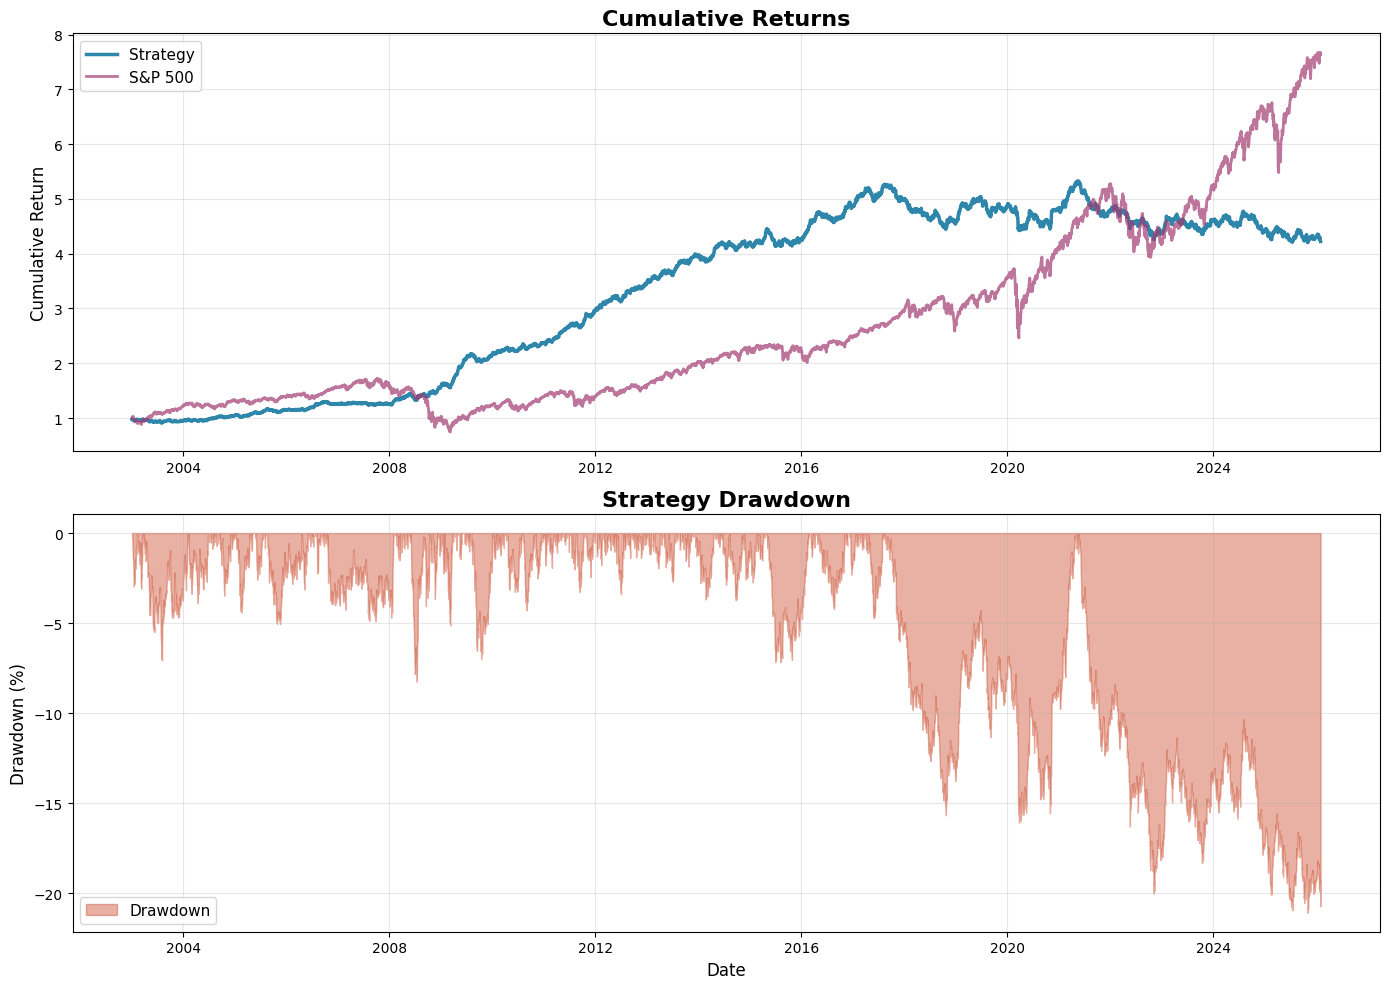


Max Drawdown: -21.07%


In [67]:
import matplotlib.pyplot as plt

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

cum_strat = (1 + strat_returns["strategy_returns"].to_numpy()).cumprod()
cum_bench = (1 + spx_aligned).cumprod()

axes[0].plot(spx_aligned.index, cum_strat, label='Strategy', linewidth=2.5, color='#2E86AB')
axes[0].plot(spx_aligned.index, cum_bench, label='S&P 500', linewidth=2, alpha=0.7, color='#A23B72')
axes[0].set_title('Cumulative Returns', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Cumulative Return', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

peak = np.maximum.accumulate(cum_strat)
dd = (cum_strat - peak) / peak

axes[1].fill_between(spx_aligned.index, 0, dd * 100, alpha=0.4, color='#C73E1D', label='Drawdown')
axes[1].set_title('Strategy Drawdown', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMax Drawdown: {dd.min()*100:.2f}%")